## Preliminaries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

%matplotlib inline     

In [12]:
df=pd.read_csv('online_shoppers_intention.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [14]:
# Turn booleans into numeric

df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

In [15]:
# show unique values of Month

len(df['Month'].unique())

10

## Modified Tanisha

#### Processing

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import plotly.express as px
import seaborn as sn
from sklearn.metrics import accuracy_score, classification_report

# Manual label encoding for month
df['Month'] = df['Month'].map(
    {'Feb': 2, 
     'Mar': 3, 
     'May': 5,
     'June':6,
     'Jul': 7,
     'Aug': 8,
     'Sep': 9,
     'Oct':10,
     'Nov':11,
     'Dec':12})

     
# mmax = MinMaxScaler()
# df['Month'] = mmax.fit_transform(df['Month'].values.reshape(-1,1))

# print(df['Month'].unique())


# Encoding for categoricals
cols_to_encode = [
    # 'Month',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'VisitorType'
]

le = OrdinalEncoder()
df[cols_to_encode] = le.fit_transform(df[cols_to_encode])

# # use pd.get_dummies for onehot encoding

# df = pd.get_dummies(df, columns=cols_to_encode)



# Deduplicate 
df.drop_duplicates(inplace=True)

# Create new numerical variables

df['TotalPages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']
df['TotalTime'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
df['Adm_time_per_page'] = (df['Administrative_Duration']/df['Administrative']).fillna(0)
df['Info_time_per_page'] = (df['Informational_Duration']/df['Informational']).fillna(0)
df['Pr_time_per_page'] = (df['ProductRelated_Duration']/df['ProductRelated']).fillna(0)
# df['Adm_proportion'] = (df['Administrative']/df['TotalPages']).fillna(0)
# df['Info_proportion'] = (df['Informational']/df['TotalPages']).fillna(0)
# df['Pr_proportion'] = (df['Administrative']/df['TotalPages']).fillna(0)


# Minmaxscale on numericals
cols_to_scale = [
    # 'Adm_proportion',
    # 'Info_proportion', 
    # 'Pr_proportion',
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'TotalPages',
    'TotalTime',
    'Adm_time_per_page',
    'Info_time_per_page',
    'Pr_time_per_page',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay']
scaler = PowerTransformer()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])



# Drop categories of pages visited
df = df.drop([
    'Administrative',
    'Informational', 
    'ProductRelated',
    # 'Administrative_Duration',
    # 'Informational_Duration',
    # 'ProductRelated_Duration'
    ], axis=1)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative_Duration  12205 non-null  float64
 1   Informational_Duration   12205 non-null  float64
 2   ProductRelated_Duration  12205 non-null  float64
 3   BounceRates              12205 non-null  float64
 4   ExitRates                12205 non-null  float64
 5   PageValues               12205 non-null  float64
 6   SpecialDay               12205 non-null  float64
 7   Month                    12205 non-null  int64  
 8   OperatingSystems         12205 non-null  float64
 9   Browser                  12205 non-null  float64
 10  Region                   12205 non-null  float64
 11  TrafficType              12205 non-null  float64
 12  VisitorType              12205 non-null  float64
 13  Weekend                  12205 non-null  int32  
 14  Revenue                  12

In [18]:
X=df.drop('Revenue',axis=1)
y=df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [19]:

# # Apply SMOTE on the encoded features and target variable
# smote = SMOTE(sampling_strategy='minority')
# X_train, y_train = smote.fit_resample(X_train, y_train)

# # Convert the resampled target variable to a pandas Series
# y_train = pd.Series(y_train)


#### Modelling

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc_tuned=RandomForestClassifier(n_estimators=100,random_state=0)
params={'n_estimators':sp_randint(1,200),
        'max_features':sp_randint(1,18),
        'max_depth': sp_randint(2,20),
        'min_samples_split':sp_randint(2,40),
        'min_samples_leaf':sp_randint(1,30),
        'criterion':['gini','entropy']}

rsearch_rfc=RandomizedSearchCV(rfc_tuned,params,cv=3,scoring='roc_auc',n_jobs=-1,random_state=0)
rsearch_rfc.fit(X_train, y_train)
rfc_tuned=RandomForestClassifier(**rsearch_rfc.best_params_,random_state=0)
rfc_tuned.fit(X_train, y_train)

#Best params {'criterion': 'entropy', 'max_depth': 19, 'max_features': 15, 'min_samples_leaf': 8, 'min_samples_split': 34, 'n_estimators': 194}

# Make predictions on the test set and evaluate model performance
y_pred = rfc_tuned.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Best params', rsearch_rfc.best_params_)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Best params {'criterion': 'entropy', 'max_depth': 19, 'max_features': 15, 'min_samples_leaf': 8, 'min_samples_split': 34, 'n_estimators': 194}
Accuracy: 0.899631298648095
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.73      0.57      0.64       382

    accuracy                           0.90      2441
   macro avg       0.83      0.76      0.79      2441
weighted avg       0.89      0.90      0.89      2441



<Axes: >

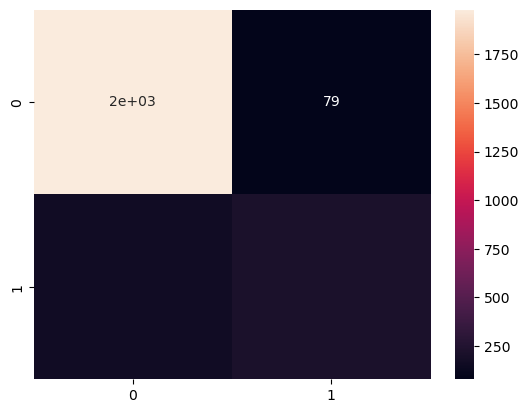

In [21]:
# confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))

sn.heatmap(cm, annot=True)

In [22]:
cm

array([[1980,   79],
       [ 166,  216]], dtype=int64)

In [23]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_,
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    fig = px.bar(
        feature_importance_df,
        text_auto = '.2f',
        labels = {'value': 'feature importance'},
        title = 'Feature importances'
    )

    fig.update_layout(showlegend = False)
    fig.show()

plot_feature_importance(rfc_tuned, X_train.columns)

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', random_state=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8639901679639492
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2059
           1       0.57      0.55      0.56       382

    accuracy                           0.86      2441
   macro avg       0.74      0.74      0.74      2441
weighted avg       0.86      0.86      0.86      2441



In [25]:
from sklearn import svm

SVM_tuned=svm.SVC(random_state=0)
params = {'C': [0.1, 1, 10, 100, 1000], 
          'degree': sp_randint(1,15),
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
          'kernel': ['rbf']} 

rsearch_svm=RandomizedSearchCV(SVM_tuned,param_distributions=params,cv=3,n_iter=200,n_jobs=-1,random_state=0)
rsearch_svm.fit(X_train, y_train)
svm_tuned=svm.SVC(**rsearch_svm.best_params_,random_state=0)
svm_tuned.fit(X_train, y_train)

#Best params {'C': 1000, 'degree': 4, 'gamma': 0.001, 'kernel': 'rbf'}

y_pred = svm_tuned.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Best params', rsearch_svm.best_params_)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Best params {'C': 1000, 'degree': 4, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.8918476034412126
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.70      0.54      0.61       382

    accuracy                           0.89      2441
   macro avg       0.81      0.75      0.77      2441
weighted avg       0.88      0.89      0.89      2441



In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=1)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

c:\Users\Irish\miniconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Accuracy: 0.8811962310528472
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2059
           1       0.64      0.54      0.59       382

    accuracy                           0.88      2441
   macro avg       0.78      0.74      0.76      2441
weighted avg       0.87      0.88      0.88      2441



In [27]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(random_state=1)
bc.fit(X_train, y_train)

y_pred = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8869315854158132
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2059
           1       0.70      0.48      0.57       382

    accuracy                           0.89      2441
   macro avg       0.81      0.72      0.75      2441
weighted avg       0.88      0.89      0.88      2441



In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=1)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8975829578041786
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.73      0.55      0.63       382

    accuracy                           0.90      2441
   macro avg       0.82      0.76      0.78      2441
weighted avg       0.89      0.90      0.89      2441



In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.8770995493650143
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2059
           1       0.63      0.51      0.56       382

    accuracy                           0.88      2441
   macro avg       0.77      0.73      0.75      2441
weighted avg       0.87      0.88      0.87      2441



In [30]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.80049160180254
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      2059
           1       0.42      0.74      0.54       382

    accuracy                           0.80      2441
   macro avg       0.68      0.78      0.71      2441
weighted avg       0.86      0.80      0.82      2441



In [31]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=100, random_state=42)
et.fit(X_train, y_train)
y_pred = et.predict(X_test)
accuracy_et = accuracy_score(y_test, y_pred)
print('Extra Trees Accuracy:', accuracy_et)

print(classification_report(y_test, y_pred))

Extra Trees Accuracy: 0.8955346169602622
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.72      0.54      0.62       382

    accuracy                           0.90      2441
   macro avg       0.82      0.75      0.78      2441
weighted avg       0.89      0.90      0.89      2441



In [32]:
from lightgbm import LGBMClassifier

lgbm_tuned= LGBMClassifier(random_state=0)
params={'n_estimators':sp_randint(2,200),
       'max_depth': sp_randint(2,30),
        'learning_rate':sp_uniform(0.001,0.05),
        'num_leaves':sp_randint(2,50)
       }

rsearch_lgbm=RandomizedSearchCV(lgbm_tuned,param_distributions=params,cv=3,n_iter=200,n_jobs=-1,random_state=0)
rsearch_lgbm.fit(X_train, y_train)
lgbm_tuned=LGBMClassifier(**rsearch_lgbm.best_params_,random_state=0)
lgbm_tuned.fit(X_train, y_train)

# Best params {'criterion': 'entropy', 'max_depth': 19, 'max_features': 15, 'min_samples_leaf': 8, 'min_samples_split': 34, 'n_estimators': 194}

y_pred = lgbm_tuned.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred)
print('LightGBM - Best params', rsearch_rfc.best_params_)
print('LightGBM Accuracy:', accuracy_lgb)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1526, number of negative: 8238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2871
[LightGBM] [Info] Number of data points in the train set: 9764, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156288 -> initscore=-1.686108
[LightGBM] [Info] Start training from score -1.686108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1526, number of negative: 8238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the

In [36]:
from xgboost import XGBClassifier

xgb_tuned=XGBClassifier(random_state=0)
params = {
        'min_child_weight': sp_randint(2,10),
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': sp_randint(2,10)
        }

rsearch_xgb=RandomizedSearchCV(xgb_tuned,param_distributions=params,cv=3,n_iter=200,n_jobs=-1,random_state=0)
rsearch_xgb.fit(X_train, y_train)

xgb_tuned=XGBClassifier(**rsearch_xgb.best_params_,random_state=0)
xgb_tuned.fit(X_train, y_train)

# Make predictions on the test set and evaluate model performance
y_pred = xgb_tuned.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Best params', rsearch_xgb.best_params_)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Best params {'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 1.0}
Accuracy: 0.8959442851290454
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.72      0.55      0.62       382

    accuracy                           0.90      2441
   macro avg       0.82      0.75      0.78      2441
weighted avg       0.89      0.90      0.89      2441



In [37]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred)
print('Logistic Regression Accuracy:', accuracy_lr)

print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8865219172470299
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2059
           1       0.66      0.57      0.61       382

    accuracy                           0.89      2441
   macro avg       0.79      0.76      0.77      2441
weighted avg       0.88      0.89      0.88      2441



In [38]:
# with lasso regularization

lr = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred)
print('Logistic Regression Accuracy:', accuracy_lr)

print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8861122490782466
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2059
           1       0.66      0.57      0.61       382

    accuracy                           0.89      2441
   macro avg       0.79      0.76      0.77      2441
weighted avg       0.88      0.89      0.88      2441



In [39]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

str_tree = export_graphviz(rfc_tuned.estimators_[0], 
   out_file=None, 
   feature_names=X_train.columns, # column names
   filled=True,        
   special_characters=True, 
   rotate=True)

graph = graphviz.Source(str_tree)

graph.render()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH